In [5]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from deepface import DeepFace
import cv2
from ultralytics import YOLO
import pandas as pd
import ast

# Модуль В. Тестирование разработанной модели

In [3]:
# инициализация модели
model = YOLO(r'runs\detect\v_3_s\weights\best.pt')

In [6]:
# данные (дФ)

df = pd.read_csv('emb_db.csv')
# преобразование строки в объект Python
df['embedding'] = df['embedding'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [35]:
# функция с распознаванием
def identity_face(img, model, df):
    '''
    Параметры функции:
    img - путь к файлу с фотографией
    model - модель детекции (YOLO)
    df - база данных в формате pandas Dataframe
    '''
    res = []
    photo = cv2.imread(img) # чтение файла с фото
    res_detect = model.predict(photo) # детекция
    if len(res_detect[0].boxes) != 0:
        if len(res_detect[0].boxes) == 1: # проверка, что найдено только одно лицо (не больше, не меньше)
            x1, y1, x2, y2 = map(int, res_detect[0].boxes.xyxy[0])
            crop_ph = photo[y1:y2, x1:x2] # обрезка фотографии
            # отображение обрезанной части картинки
            plt.figure(figsize=(5, 5))
            plt.imshow(crop_ph)
            plt.title('Cropped Image') 
            plt.axis('off')
            plt.show()
            try:
                # вычисление эмбеддинга
                embedding_input = DeepFace.represent(img_path = crop_ph, model_name='VGG-Face')[0]['embedding'] 
                max_prob = 0.4 # переменная для записи наилучшего совпадения, минимальное совпадение 40%
                best_res = None # переменная для записи всей строки из датафрейма, в которой хранится наилучшее совпадение
                for i, embedding_db in enumerate(df['embedding']): # проходимся по колонке с эмбеддингами
                    similarity = cosine_similarity([embedding_input], [embedding_db])[0][0] # вычисление косинусной схожести
                    if similarity > max_prob:
                        max_prob = similarity
                        best_res = df.iloc[i]
                # если переменная best_res не пустая, выводим результат
                if best_res is not None:
                    res = {'Name': best_res['Name'], 'similarity': max_prob}
                    print(f'Имя: {res["Name"]}\nСовпадение: {res["similarity"]}')
                    
                    # добавляю вывод фотографии из бд
                    res_photo_p = best_res['f_path']
                    res_answ = cv2.cvtColor(cv2.imread(res_photo_p), cv2.COLOR_BGR2RGB)
                    plt.figure(figsize=(5, 5))
                    plt.imshow(res_answ)
                    plt.title('Cropped Image') 
                    plt.axis('off')
                    plt.show()
                    return res
                else:
                    print('Совпадения не найдены')
                    return None
            except:
                print('Лицо не обнаружено')
                return None
        else:
            print('Ошибка, обнаружено много лиц. Пожалйста, выберите фото с одним лицом.')
            return None
    else:
        print('Лицо не обнаружено')
        return None

## Тест-кейсы

Для тест-кейсов я буду мешать фотографии из тестовой выборки и взятые из интернета.

**из интернета будут браться фотографии только тех людей, которые есть в обучающей выборке

В тест кейсах я хочу проверить, как будет отрабатывать функция, если взять фотографии людей, у которого мало фотографий в обучающей выборке

Пример: в папке Zhu_Rongji в обучающей выборке всего 3 фотографии

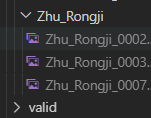](attachment:image.png)

Ещё я возьму фотографии из интернета с разными освещением и ракурсами, а так же фотографии одного и того же человека, но в разном возрасте

### Тест-кейс №1

#### Тест 1


0: 640x640 1 face, 238.1ms
Speed: 5.2ms preprocess, 238.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


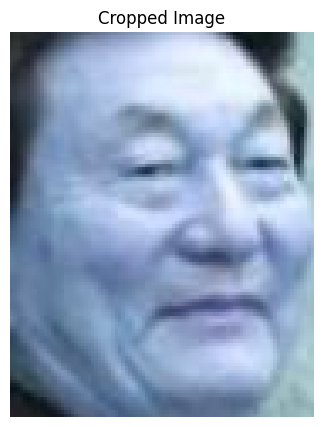

Имя: Zhu_Rongji
Совпадение: 0.860091547323083


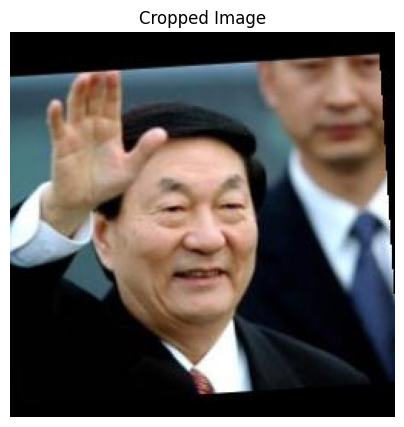

{'Name': 'Zhu_Rongji', 'similarity': np.float64(0.860091547323083)}

In [18]:
identity_face(r'id_data\test\Zhu_Rongji\Zhu_Rongji_0001.jpg', model, df) # файл взят из тестовой выборки

#### Тест 2


0: 640x640 1 face, 191.9ms
Speed: 7.0ms preprocess, 191.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


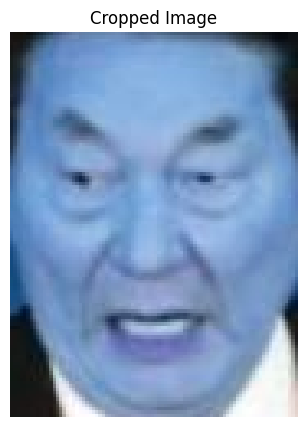

Имя: Zhu_Rongji
Совпадение: 0.7486590821365589


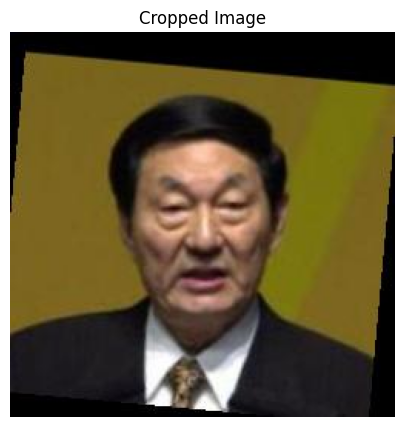

{'Name': 'Zhu_Rongji', 'similarity': np.float64(0.7486590821365589)}

In [19]:
identity_face(r'id_data\test\Zhu_Rongji\Zhu_Rongji_0004.jpg', model, df)

#### Тест 3


0: 640x640 1 face, 191.3ms
Speed: 5.5ms preprocess, 191.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


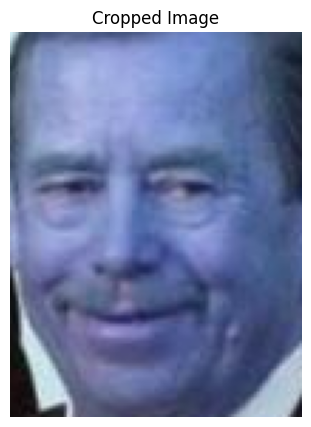

Имя: Vaclav_Havel
Совпадение: 0.6458716797400108


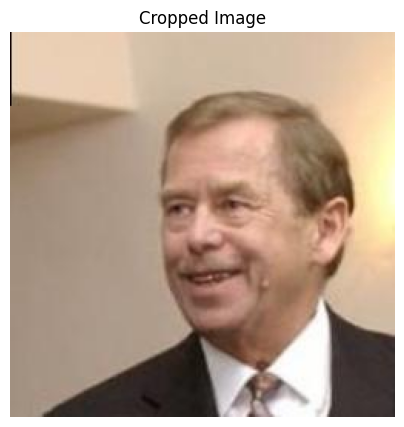

{'Name': 'Vaclav_Havel', 'similarity': np.float64(0.6458716797400108)}

In [21]:
identity_face(r'id_data\test\Vaclav_Havel\Vaclav_Havel_0003.jpg', model, df)

#### Ввод по первому тест-кейсу:

* Распознавание верно, но у последнего кейса значение косинусной схожести довольно низкое (64%), если учитывать схожесть фотографий и то, что вероятнее всего они были сделаны в один день (на фото одинаковая одежда и фон)

### Тест-кейс 2

#### Тест 1


0: 448x640 1 face, 212.7ms
Speed: 3.0ms preprocess, 212.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


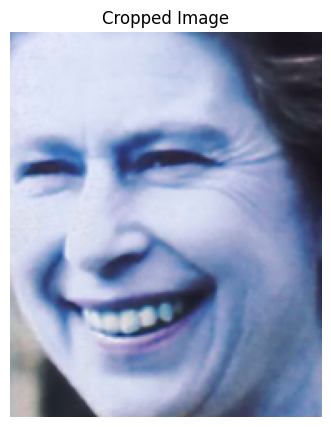

Имя: Queen_Elizabeth_II
Совпадение: 0.6111916888429745


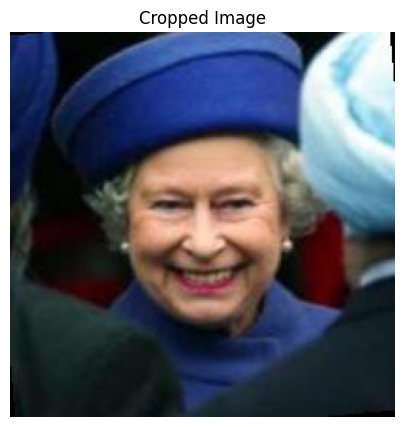

{'Name': 'Queen_Elizabeth_II', 'similarity': np.float64(0.6111916888429745)}

In [24]:
identity_face(r'elizabeth_II_inet.png', model, df)

#### Тест 2


0: 640x544 1 face, 204.3ms
Speed: 4.5ms preprocess, 204.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


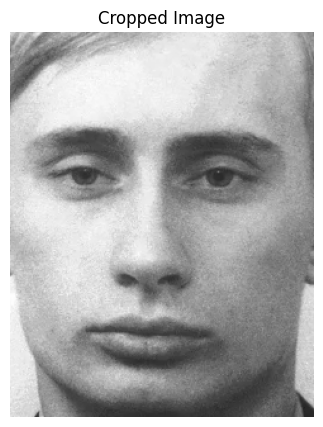

Имя: Vladimir_Putin
Совпадение: 0.43637235276061065


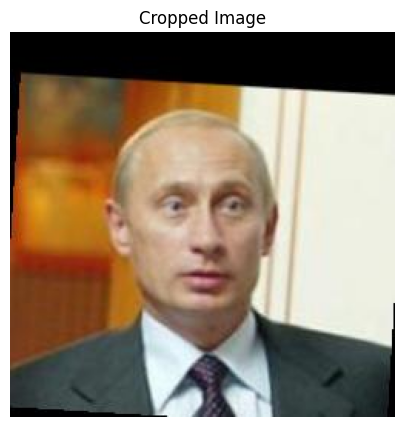

{'Name': 'Vladimir_Putin', 'similarity': np.float64(0.43637235276061065)}

In [27]:
identity_face(r'putin_yang.png', model, df)

#### Тест 3


0: 640x640 1 face, 232.6ms
Speed: 6.0ms preprocess, 232.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


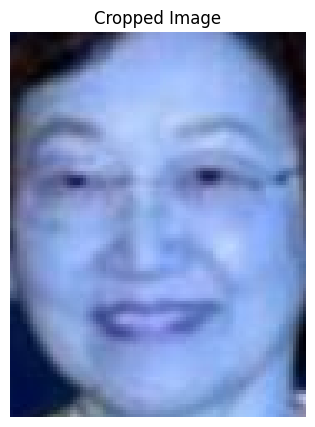

Имя: Yoriko_Kawaguchi
Совпадение: 0.8103053286206849


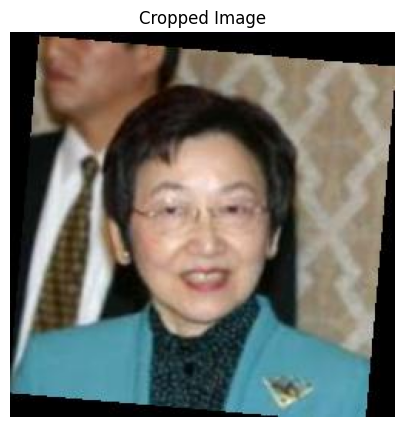

{'Name': 'Yoriko_Kawaguchi', 'similarity': np.float64(0.8103053286206849)}

In [38]:
identity_face(r'id_data\test\Yoriko_Kawaguchi\Yoriko_Kawaguchi_0010.jpg', model, df)

#### Вывод по второму тест-кейсу:

* Первое фото было взято из интернета, лицо было идентифицировано верно. Сходство 61%, что не очень много, но учитывая различия в том, как постановку фотографии и разный возраст (хотя разница не сильно большая), результат хороший

* Второе фото тоже опознано верно. Сходство всего 43%, НО помимо того, что фотография чёрно белая, на ней Путин сильно молодой и с волосами (в обучающей выборке он везде лысый или почти лысый), поэтому можно сказать, что результат вполне себе хороший.

* На третьем фото и результат предсказания верный, и сходство большое (81%)

### Тест-кейс 3

#### Тест 1


0: 640x512 1 face, 168.7ms
Speed: 5.0ms preprocess, 168.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


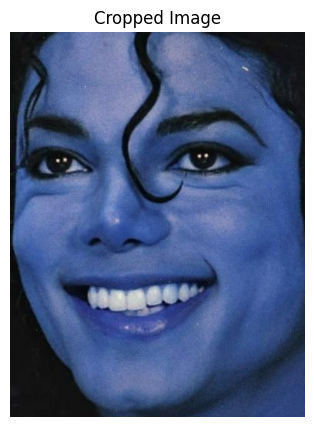

Имя: Michael_Jackson
Совпадение: 0.42980884935512254


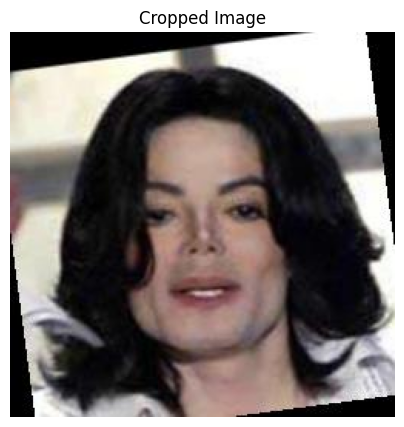

{'Name': 'Michael_Jackson', 'similarity': np.float64(0.42980884935512254)}

In [30]:
identity_face(r'Michael_Jackson _inet1.jpg', model, df)

#### Тест 2


0: 640x640 1 face, 193.6ms
Speed: 6.0ms preprocess, 193.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


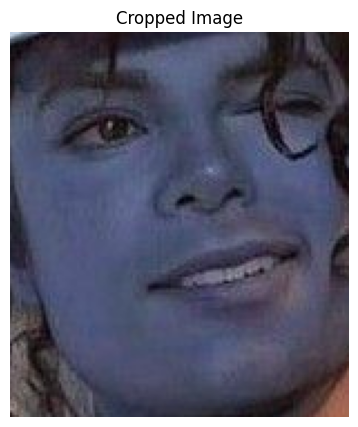

Имя: Michael_Jackson
Совпадение: 0.5303103683683488


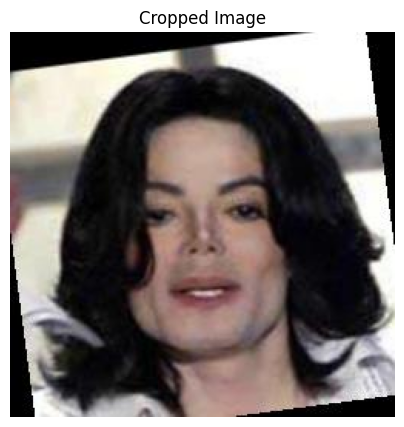

{'Name': 'Michael_Jackson', 'similarity': np.float64(0.5303103683683488)}

In [31]:
identity_face(r'Michael_Jackson _inet2.jpg', model, df)

#### Тест 3


0: 640x448 1 face, 190.9ms
Speed: 4.0ms preprocess, 190.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


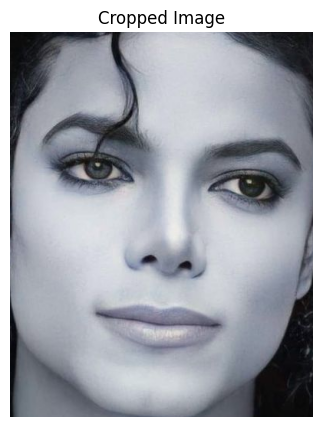

Имя: Michael_Jackson
Совпадение: 0.46006903465201543


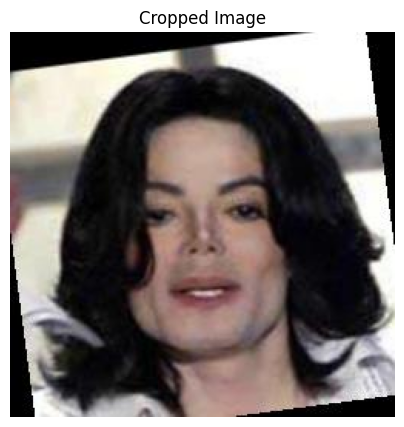

{'Name': 'Michael_Jackson', 'similarity': np.float64(0.46006903465201543)}

In [32]:
identity_face(r'Michael_Jackson _inet3.jpg', model, df)

#### Вывод по третьему тест-кейсу:

* На всех фотографиях один человек, все фото взяты из интернета, одна из них чёрно-белая. Результат предсказания правильный, схожесть по всем фото не очень сильно различается (42%, 53% и 46%)

### Тест-кейс №4

#### Тест 1


0: 640x640 1 face, 219.3ms
Speed: 6.5ms preprocess, 219.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


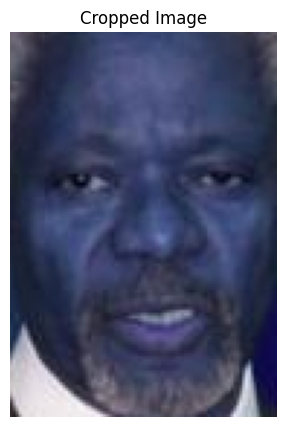

Имя: Kofi_Annan
Совпадение: 0.8195434309160693


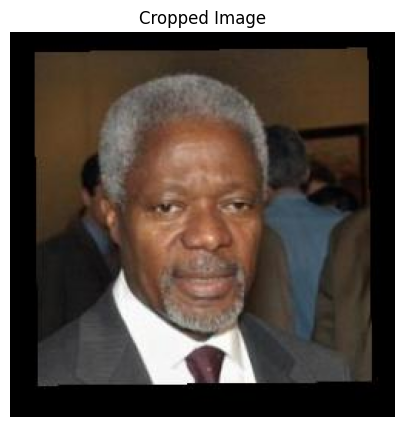

{'Name': 'Kofi_Annan', 'similarity': np.float64(0.8195434309160693)}

In [39]:
identity_face(r'id_data\test\Kofi_Annan\Kofi_Annan_0031.jpg', model, df)

#### Тест 2


0: 384x640 1 face, 157.1ms
Speed: 4.0ms preprocess, 157.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


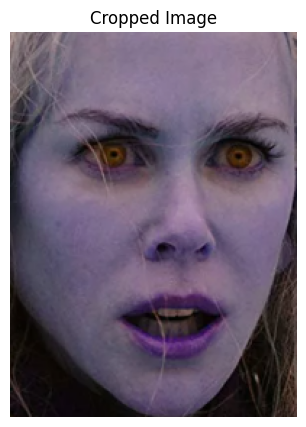

Имя: Nicole_Kidman
Совпадение: 0.4598668524658321


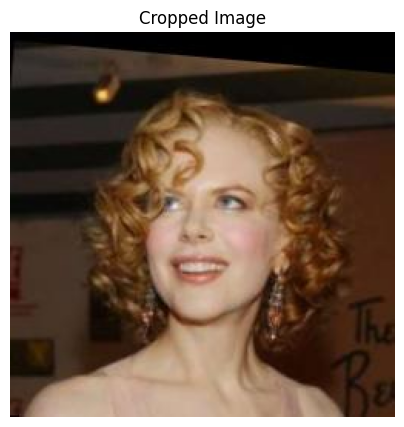

{'Name': 'Nicole_Kidman', 'similarity': np.float64(0.4598668524658321)}

In [41]:
identity_face(r'nikole_kidman_film1.png', model, df)

#### Тест 3

0: 640x640 1 face, 200.3ms
Speed: 7.0ms preprocess, 200.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


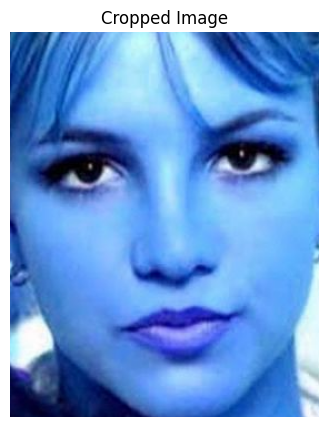

Имя: Britney_Spears
Совпадение: 0.42606382491285266


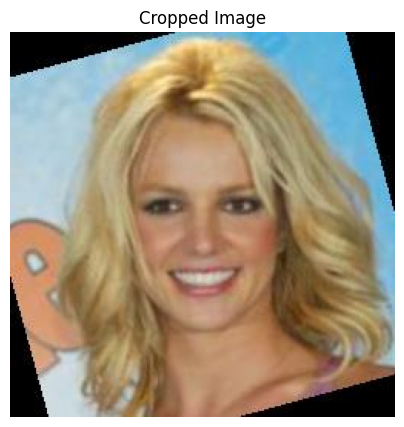

{'Name': 'Britney_Spears', 'similarity': np.float64(0.42606382491285266)}

In [45]:
identity_face(r'britney_spears_inet1.jpg', model, df)

#### Вывод по четвёртому тест кейсу:

* Результат предсказан правильно

* Для второго фото я взяла Николь Кидман в роли кого-то там в фильме "Аквамен" и модель правильно её опознала, на что я мало рассчитывала

### Тест-кейс №5

#### Тест 1


0: 640x480 1 face, 154.1ms
Speed: 5.0ms preprocess, 154.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


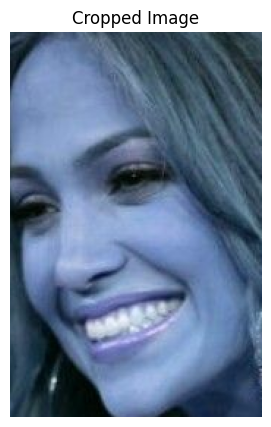

Имя: Jennifer_Lopez
Совпадение: 0.5691176322055422


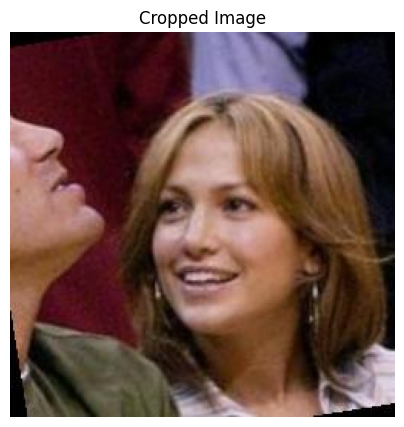

{'Name': 'Jennifer_Lopez', 'similarity': np.float64(0.5691176322055422)}

In [46]:
identity_face(r'jennifer_lopez_inet1.jpg', model, df)

#### Тест 2

0: 640x448 1 face, 206.4ms
Speed: 3.0ms preprocess, 206.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


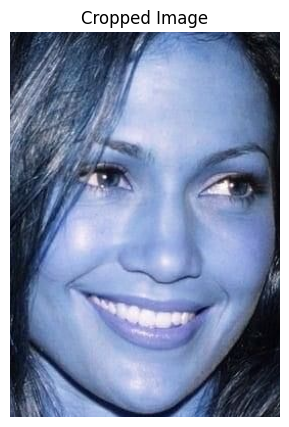

Имя: Jennifer_Lopez
Совпадение: 0.6123084961958349


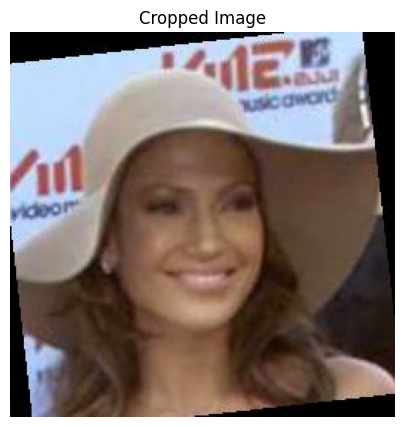

{'Name': 'Jennifer_Lopez', 'similarity': np.float64(0.6123084961958349)}

In [48]:
identity_face(r'jennifer_lopez_inet2.jpg', model, df)

#### Тест 3


0: 640x640 1 face, 202.7ms
Speed: 6.0ms preprocess, 202.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


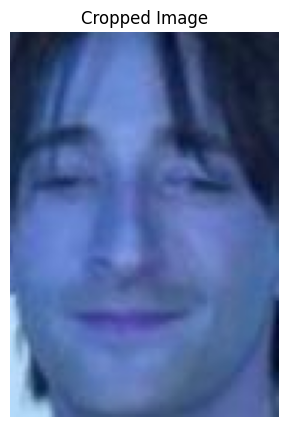

Имя: Adrien_Brody
Совпадение: 0.6094826521915282


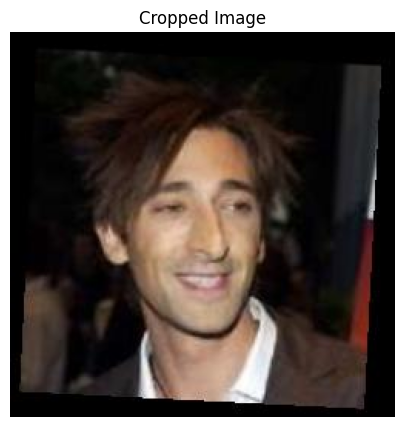

{'Name': 'Adrien_Brody', 'similarity': np.float64(0.6094826521915282)}

In [49]:
identity_face(r'id_data\test\Adrien_Brody\Adrien_Brody_0010.jpg', model, df)

#### Вывод о пятом тест-кейсе:

* Предсказания правильные, все сходства в данном тест-кейсе больше 50-ти%

### Тест-кейс №6

#### Тест 1


0: 640x640 1 face, 211.4ms
Speed: 6.5ms preprocess, 211.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


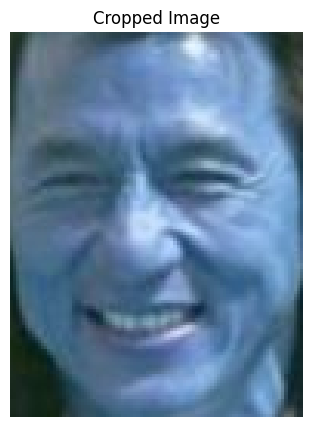

Имя: Jackie_Chan
Совпадение: 0.624931908042033


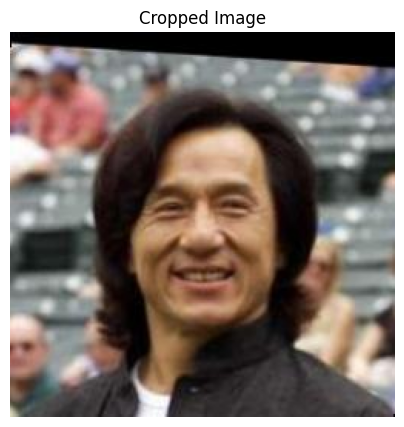

{'Name': 'Jackie_Chan', 'similarity': np.float64(0.624931908042033)}

In [50]:
identity_face(r'id_data\test\Jackie_Chan\Jackie_Chan_0013.jpg', model, df)

#### Тест 2

0: 640x448 1 face, 193.8ms
Speed: 4.0ms preprocess, 193.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


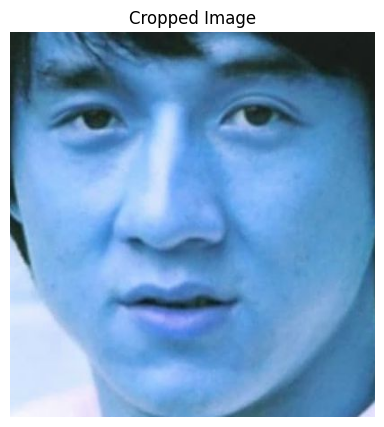

Имя: Jackie_Chan
Совпадение: 0.4932870301576047


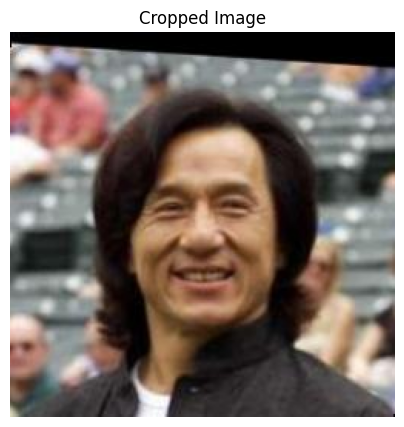

{'Name': 'Jackie_Chan', 'similarity': np.float64(0.4932870301576047)}

In [52]:
identity_face(r'Jackie_Chan_yang_1.jpg', model, df)

#### Тест 3


0: 416x640 1 face, 185.3ms
Speed: 3.0ms preprocess, 185.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


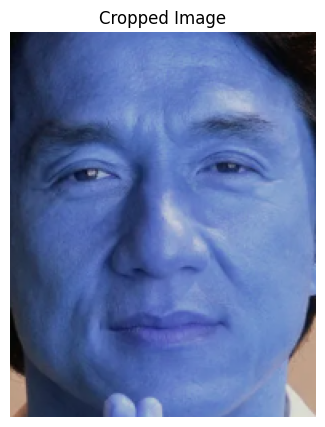

Имя: Jackie_Chan
Совпадение: 0.6737569284386642


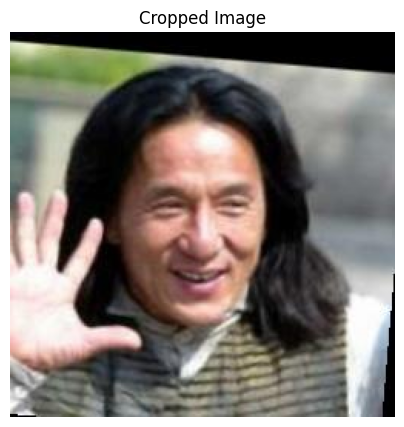

{'Name': 'Jackie_Chan', 'similarity': np.float64(0.6737569284386642)}

In [55]:
identity_face(r'Jackie_Chan_inet2.png', model, df)

#### Вывод по шестому тест-кейсу:

* Тест-кейс по Джеки Чану, предсказания все верны

### Тест-кейс №7

#### Тест 1


0: 640x640 1 face, 197.2ms
Speed: 5.0ms preprocess, 197.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


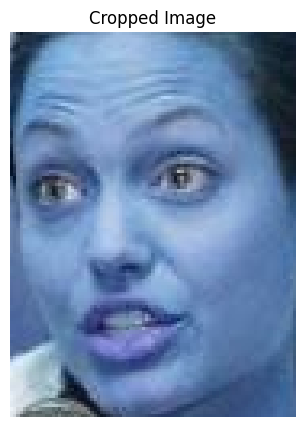

Имя: Angelina_Jolie
Совпадение: 0.5937672723140006


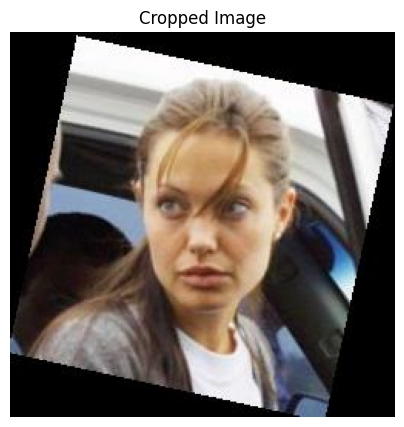

{'Name': 'Angelina_Jolie', 'similarity': np.float64(0.5937672723140006)}

In [56]:
identity_face(r'id_data\test\Angelina_Jolie\Angelina_Jolie_0019.jpg', model, df)

#### Тест 2

0: 640x480 1 face, 211.9ms
Speed: 4.0ms preprocess, 211.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


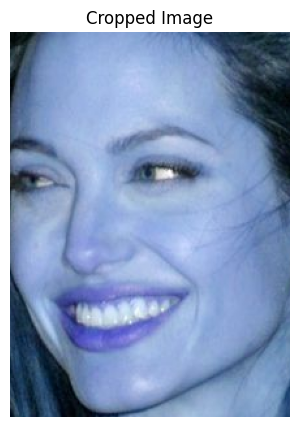

Имя: Angelina_Jolie
Совпадение: 0.5814041603954979


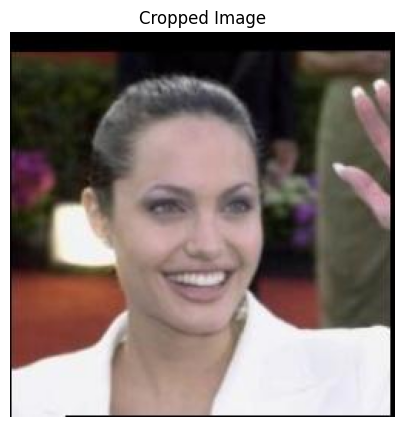

{'Name': 'Angelina_Jolie', 'similarity': np.float64(0.5814041603954979)}

In [58]:
identity_face(r'Angelina_Jolie_inet1.jpg', model, df)

#### Тест 3


0: 640x640 1 face, 202.9ms
Speed: 12.0ms preprocess, 202.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


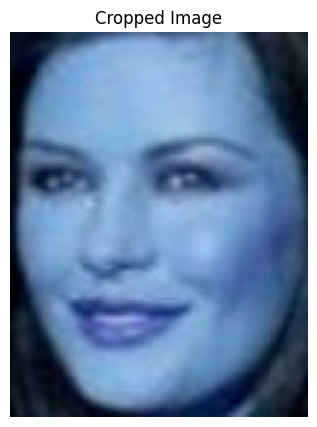

Имя: Catherine_Zeta-Jones
Совпадение: 0.5813749275918361


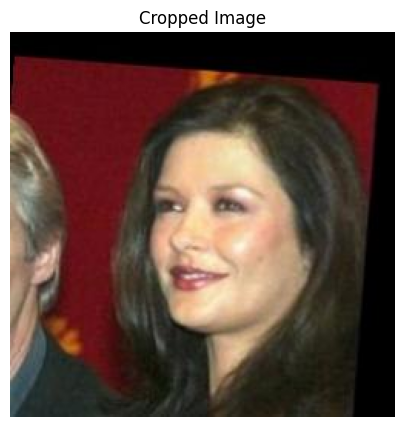

{'Name': 'Catherine_Zeta-Jones', 'similarity': np.float64(0.5813749275918361)}

In [59]:
identity_face(r'id_data\test\Catherine_Zeta-Jones\Catherine_Zeta-Jones_0003.jpg', model, df)

#### Вывод о седьмом тест-кейсе:

* Люди со всех трёх фотографиях были идентифицированы верно.

* Маленькое наблюдение-совпадение: в этом тест кейсе получилось так, что значение косинусной схожести грубо говоря одно и то же (59, 58 и 58 процентов соответственно тому, как идут фото выше)

____________________________________________________________________________________________

## Отчёт

* Реализованы 7 тест-кейсов, для которых были отобраны разные фотографии